## CONFIG

In [1]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
from pathlib import Path
import os

In [2]:
DATA_PATH = '/content/drive/MyDrive/pnu project/object_detection/data'
TRAINING_PATH = os.path.join(DATA_PATH,'training_images')
TESTING_PATH = os.path.join(DATA_PATH,'testing_images')
CSV_PATH = os.path.join(DATA_PATH,'train_solution_bounding_boxes.csv')

DATA_PATH, TRAINING_PATH, TESTING_PATH, CSV_PATH

('/content/drive/MyDrive/pnu project/object_detection/data',
 '/content/drive/MyDrive/pnu project/object_detection/data/training_images',
 '/content/drive/MyDrive/pnu project/object_detection/data/testing_images',
 '/content/drive/MyDrive/pnu project/object_detection/data/train_solution_bounding_boxes.csv')

In [3]:
type(TESTING_PATH)

str

In [4]:
train_path = Path(TRAINING_PATH)
test_path = Path(TESTING_PATH)
csv_path = Path(CSV_PATH)

In [5]:
train = pd.read_csv(csv_path)
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

## UTILS

In [6]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def display_image_from_file(name, bbox_coords=[], path=train_path):
    path_read = str(path)+'/'+name
    img = cv2.imread(path_read)
    print(path_read)
    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {path_read}")
        return # Exit the function if the image wasn't loaded

    # Convert BGR image to RGB for displaying with matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    display_image(img, bbox_coords=bbox_coords)

def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)


def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))

    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_1000.jpg


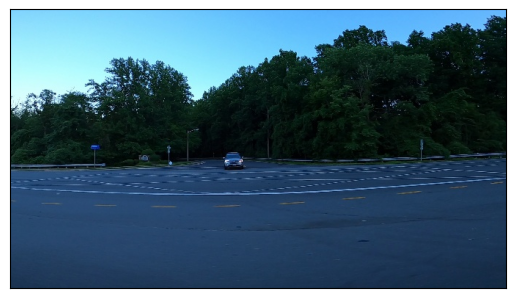

In [7]:
display_image_from_file("vid_4_1000.jpg")

/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_22740.jpg
/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_920.jpg
/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_12340.jpg


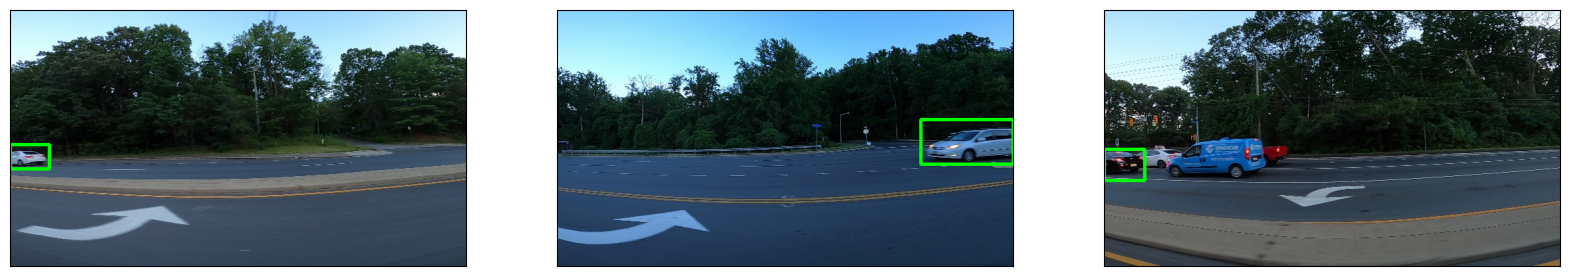

In [8]:
display_grid()


## Modeling

In [9]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                # Ensure the numpy array is created with float32 dtype
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax], dtype=np.float32)

        # Create a TensorFlow tensor of type tf.float32 for the bounding box coordinates
        coords_tensor = tf.convert_to_tensor(bounding_box_coords, dtype=tf.float32)

        yield {'image': images}, {'coords': coords_tensor}

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   355 non-null    object
 1   xmin    355 non-null    int64 
 2   ymin    355 non-null    int64 
 3   xmax    355 non-null    int64 
 4   ymax    355 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 14.0+ KB


True Label Test

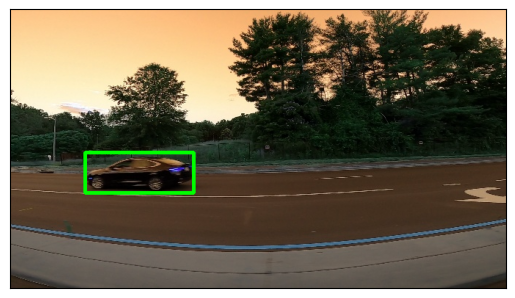

In [11]:
# Test the generator
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

In [12]:
label

{'coords': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[102., 195., 250., 250.]], dtype=float32)>}

### Model Building

In [13]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 380, 676, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 380, 676, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 380, 676, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 190, 338, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 190, 338, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 190, 338, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 95, 169, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 95, 169, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 95, 169, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 11, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 11, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 11, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 101,761,236 (388.19 MB)

 Trainable params: 101,744,868 (388.13 MB)

 Non-trainable params: 16,368 (63.94 KB)

In [15]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

In [16]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)

    X = example['image']
    y = label['coords']

    pred_bbox = model.predict(X)[0]

    img = X[0]
    gt_coords = y[0]

    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


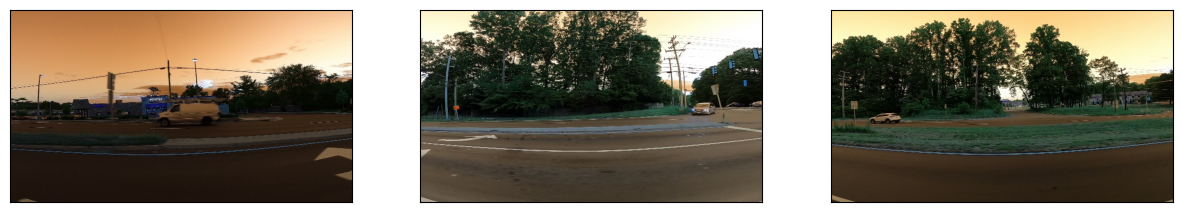

In [17]:
test(model)

Still bad haha, we have not train it

In [18]:
# with tf.device('/GPU:0'):
#     _ = model.fit(
#         data_generator(),
#         epochs=9,
#         steps_per_epoch=500,
#         callbacks=[
#             ShowTestImages(),
#         ]
#     )

Epoch 1/9


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: image
Received: inputs=['Tensor(shape=(None, 380, 676, 3))']
  warnings.warn(msg)


TypeError: Expected float32, but got coords of type 'str'.

Original data types:
xmin    float64
ymin    float64
xmax    float64
ymax    float64
dtype: object
Sample values:
         xmin        ymin        xmax        ymax
0  281.259045  187.035071  327.727931  223.225547
1   15.163531  187.035071  120.329957  236.430180
2  239.192475  176.764801  361.968162  236.430180
3  496.483358  172.363256  630.020260  231.539575
4   16.630970  186.546010  132.558611  238.386422
After cleaning:
xmin    int32
ymin    int32
xmax    int32
ymax    int32
dtype: object
Number of samples: 355
/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_1000.jpg
/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_28220.jpg
/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_2020.jpg
/content/drive/MyDrive/pnu project/object_detection/data/training_images/vid_4_9060.jpg
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 5 columns):
 #   Column  Non-Nul

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 380, 676, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 380, 676, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 380, 676, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 190, 338, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 190, 338, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 190, 338, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 95, 169, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 95, 169, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 95, 169, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 85, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 48, 85, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 43, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 12, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 11, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 6, 11, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 6, 11, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 101,761,236 (388.19 MB)

 Trainable params: 101,744,868 (388.13 MB)

 Non-trainable params: 16,368 (63.94 KB)

Testing model before training...


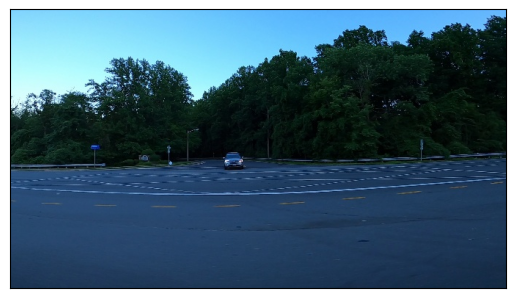

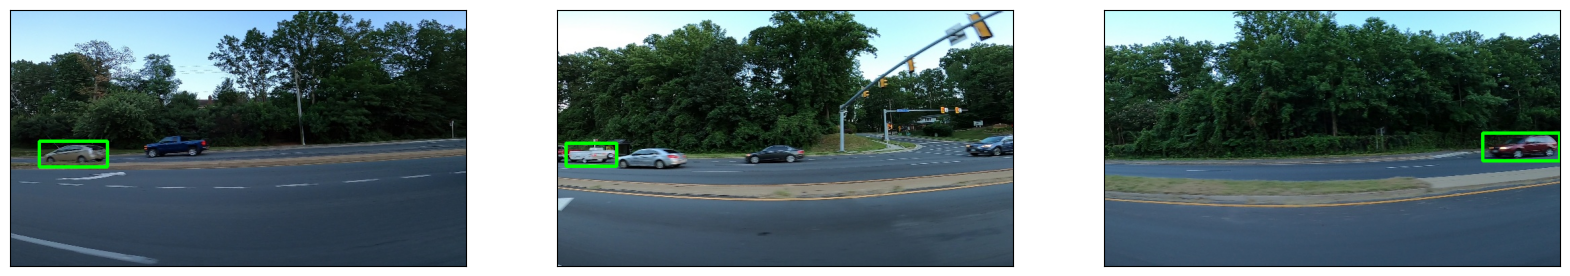

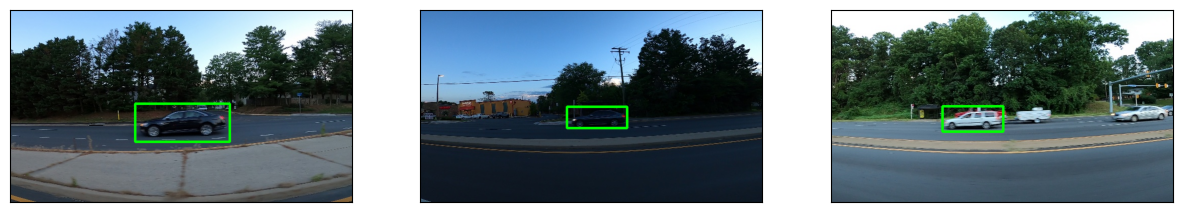

GPU Available:  []
Epoch 1/9
  4/500 ━━━━━━━━━━━━━━━━━━━━ 2:19:35 17s/step - loss: 53583.5781 - mae: 198.0115

In [ ]:
# -*- coding: utf-8 -*-
"""modeling_1.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1nqhOLajzLi7QpPiH3CAicOzrOn5apkuD

## CONFIG
"""

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization/Image Processing
import cv2
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
from pathlib import Path
import os

DATA_PATH = '/content/drive/MyDrive/pnu project/object_detection/data'
TRAINING_PATH = os.path.join(DATA_PATH,'training_images')
TESTING_PATH = os.path.join(DATA_PATH,'testing_images')
CSV_PATH = os.path.join(DATA_PATH,'train_solution_bounding_boxes.csv')

DATA_PATH, TRAINING_PATH, TESTING_PATH, CSV_PATH

type(TESTING_PATH)

train_path = Path(TRAINING_PATH)
test_path = Path(TESTING_PATH)
csv_path = Path(CSV_PATH)

# Fixed data loading with better error handling
train = pd.read_csv(csv_path)

# Check data types and handle potential string values
print("Original data types:")
print(train[['xmin', 'ymin', 'xmax', 'ymax']].dtypes)
print("Sample values:")
print(train[['xmin', 'ymin', 'xmax', 'ymax']].head())

# Convert to numeric, handling any non-numeric values
for col in ['xmin', 'ymin', 'xmax', 'ymax']:
    train[col] = pd.to_numeric(train[col], errors='coerce')

# Remove rows with NaN values (if any non-numeric values were found)
train = train.dropna(subset=['xmin', 'ymin', 'xmax', 'ymax']).reset_index(drop=True)

# Convert to int after ensuring they're numeric
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(np.int32)

# Remove duplicates
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

print("After cleaning:")
print(train[['xmin', 'ymin', 'xmax', 'ymax']].dtypes)
print(f"Number of samples: {len(train)}")

"""## UTILS"""

def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def display_image_from_file(name, bbox_coords=[], path=train_path):
    path_read = str(path)+'/'+name
    img = cv2.imread(path_read)
    print(path_read)
    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Could not load image from {path_read}")
        return # Exit the function if the image wasn't loaded

    # Convert BGR image to RGB for displaying with matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    display_image(img, bbox_coords=bbox_coords)

def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)

def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))

    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

# Test display
if len(train) > 0:
    display_image_from_file(train.iloc[0]['image'])
    display_grid()

"""## Modeling"""

def data_generator(df=train, batch_size=16, path=train_path):
    while True:
        # Pre-allocate arrays
        images = np.zeros((batch_size, 380, 676, 3), dtype=np.float32)
        bounding_box_coords = np.zeros((batch_size, 4), dtype=np.float32)

        for i in range(batch_size):
            try:
                # Get random sample
                rand_index = np.random.randint(0, len(df))
                row = df.iloc[rand_index]

                # Load and preprocess image
                img_path = str(path / row['image'])
                img = cv2.imread(img_path)

                if img is None:
                    print(f"Warning: Could not load image {img_path}")
                    continue

                # Convert BGR to RGB and normalize
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype(np.float32) / 255.0
                images[i] = img

                # Extract coordinates and ensure they're float32
                coords = [
                    float(row['xmin']),
                    float(row['ymin']),
                    float(row['xmax']),
                    float(row['ymax'])
                ]
                bounding_box_coords[i] = np.array(coords, dtype=np.float32)

            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                # Use default values if there's an error
                images[i] = np.zeros((380, 676, 3), dtype=np.float32)
                bounding_box_coords[i] = np.array([0.0, 0.0, 100.0, 100.0], dtype=np.float32)

        # Yield tensors directly instead of dictionaries
        yield images, bounding_box_coords

train.info()

"""True Label Test"""

# Test the generator
print("Testing data generator...")
try:
    images, bbox_coords = next(data_generator(batch_size=1))
    img = images[0]
    bbox_coord = bbox_coords[0]

    print(f"Image shape: {img.shape}, dtype: {img.dtype}")
    print(f"Bbox coords: {bbox_coord}, dtype: {bbox_coord.dtype}")

    display_image(img, bbox_coords=bbox_coord, norm=True)
    print(f"Coordinates: {bbox_coord}")
except Exception as e:
    print(f"Error in data generator test: {e}")

"""### Model Building"""

input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)

model.summary()

model.compile(
    loss='mse',  # Simple loss since we have single output
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=['mae']  # Mean Absolute Error for regression
)

# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    try:
        images, bbox_coords = next(datagen)

        pred_bbox = model.predict(images, verbose=0)[0]

        img = images[0]
        gt_coords = bbox_coords[0]

        display_image(img, bbox_coords=gt_coords, pred_coords=pred_bbox, norm=True)
    except Exception as e:
        print(f"Error in test_model: {e}")

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

# Test before training
print("Testing model before training...")
test(model)

"""Training the model"""

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

try:
    with tf.device('/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'):
        history = model.fit(
            data_generator(),
            epochs=9,
            steps_per_epoch=500,
            callbacks=[
                ShowTestImages(),
            ],
            verbose=1
        )
except Exception as e:
    print(f"Training error: {e}")
    # Try with smaller batch size or fewer steps if there's a memory issue
    print("Retrying with smaller steps...")
    try:
        history = model.fit(
            data_generator(batch_size=8),  # Smaller batch size
            epochs=40,
            steps_per_epoch=100,
            verbose=1
        )
    except Exception as e2:
        print(f"Second attempt failed: {e2}")

In [ ]:
!pwd

/content


In [ ]:
# model.save('/content/drive/MyDrive/pnu project/object_detection/model/car-object-detection--iter-1.h5')

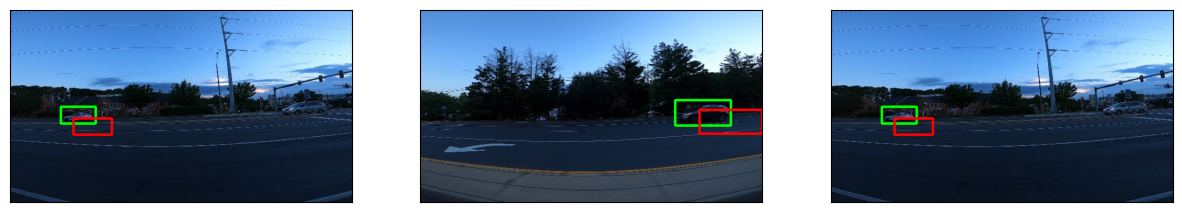

In [ ]:
test(model)

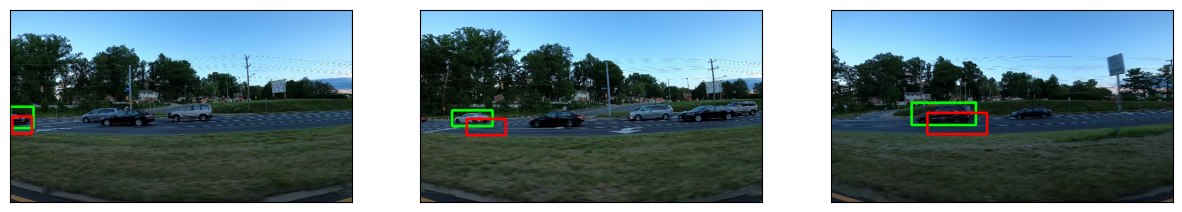

In [ ]:
test(model)

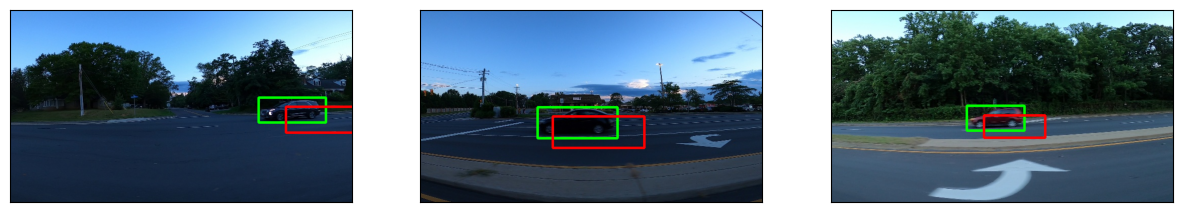

In [ ]:
test(model)

In [ ]:
# # Save in TensorFlow's SavedModel format
# NAME_OUTPUT = 'car_detection_savedmodel--iter-1'
# tf.saved_model.save(model, NAME_OUTPUT)

In [ ]:
model.save('/content/drive/MyDrive/pnu project/object_detection/model/'+'car_detection_model_dir')

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/drive/MyDrive/pnu project/object_detection/model/car_detection_model_dir.

In [ ]:
'/content/drive/MyDrive/pnu project/object_detection/model'+'/'+'car_detection_model_dir'

'/content/drive/MyDrive/pnu project/object_detection/model/car_detection_model_dir'

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/pnu project/object_detection/model/car_detection_model--iter-1.keras')

# Load the model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/pnu project/object_detection/model/car_detection_model--iter-1.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


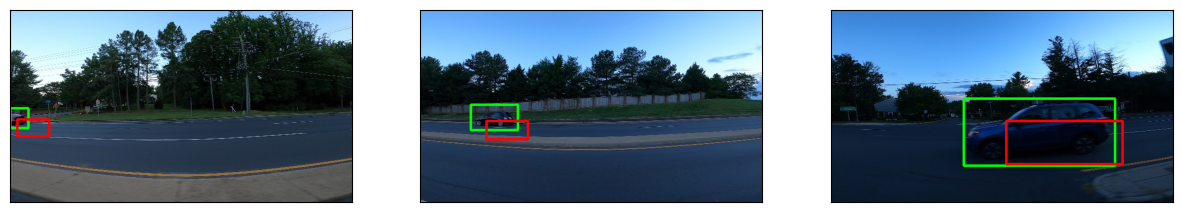

In [ ]:
test(loaded_model)